In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import gc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
SampleSubmission = pd.read_csv("../input/zindi-dataset/SampleSubmission.csv")
data = pd.read_csv("../input/zindi-dataset/Train.csv")

In [3]:
train_cols = ['X', 'Y', 'target_2015', 'elevation', 'precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15','LC_Type1_mode', 'Square_ID']

test_cols =['X', 'Y', 'elevation','precip 2019-01-20 - 2019-01-27', 
            'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
       'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
       'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
       'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
       'precip 2019-05-12 - 2019-05-19', 'LC_Type1_mode', 'Square_ID']

In [4]:
train = data[train_cols]
test = data[test_cols]
train.shape, test.shape

((16466, 23), (16466, 22))

In [5]:
def transform_col_names(original_cols) :
    new_cols =[]
    compt_back = -17
    for i in original_cols :
        if i.startswith('precip') :
            new_cols.append('precip'+str(compt_back))
            compt_back+=1
        else :
            new_cols.append(i)
    return new_cols

In [6]:
new_train_cols = transform_col_names(train_cols)
new_test_cols = transform_col_names(test_cols)

train.columns = new_train_cols
test.columns = new_test_cols

In [7]:
full_data = pd.concat([train, test], 0).reset_index(drop=True)

**Let's Add the Slope : the Slope extraction is Done in R Language Using the Notebook "Terrain Features"that you can find enclosed.**

In [8]:
slope = pd.read_csv("../input/raster-terrain/terrain.csv")
slope.slope.fillna(method='ffill', inplace=True)
slope.slope.fillna(method='bfill', inplace=True)
slope = slope[["lon","lat","slope"]]

# lon_lat are already in the suitable order, no need to merge :p :
full_data["slope"] = slope["slope"]

Now let's include Soil data, which you can find on the following link (Website allowed by Zindi) : 
* http://www.masdap.mw/layers/geonode:mw_soils

* The Aggregation between Malawi Shapefiles and The points in the Train_Test File is Done using **DivaGIS** Software (Open Source Software Allowed By Zindi).
* The output of the **DivaGIS** is the following "soil_data.txt" File.

In [9]:
from sklearn.preprocessing import LabelEncoder
def le_encoder(df) :
    df = df.apply(LabelEncoder().fit_transform)
    return df

In [10]:
soil = pd.read_csv("../input/soill-data/soil_data.txt", delimiter="\t")
for i in soil.columns:
    soil[str(i)].fillna(method='ffill', inplace=True)
    soil[str(i)].fillna(method='bfill', inplace=True)
obj_list=[]
for i in soil.columns :
    if soil[i].dtype == "O" :
        obj_list.append(i)
soil[obj_list] = le_encoder(soil[obj_list].astype(str))
soil.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,X,fid,AREA,PERIMETER,MW_SOILS_,MW_SOILS_I,SOIL_TYPE,PRIMARY,SECONDARY,FAO_CLASSI,...,FLOODING,PONDING,SREACT1,SREACT2,SALINITY,CEC,N,P,K,bilel
0,34.26,3910.0,1.050650e+07,32255.322,3786.0,3785.0,87,66,33,19,...,7,2,4,5.5,6,0,5,0,0,2
1,34.26,3910.0,1.050650e+07,32255.322,3786.0,3785.0,87,66,33,19,...,7,2,4,5.5,6,0,5,0,0,2
2,34.26,3910.0,1.050650e+07,32255.322,3786.0,3785.0,87,66,33,19,...,7,2,4,5.5,6,0,5,0,0,2
3,34.26,3915.0,1.653534e+06,5815.810,3773.0,3772.0,80,61,33,6,...,7,2,4,5.5,6,0,5,0,0,2
4,34.26,3915.0,1.653534e+06,5815.810,3773.0,3772.0,80,61,33,6,...,7,2,4,5.5,6,0,5,0,0,2


After Some Tests and Data explorations, we found that the following Features are the most important ones

In [11]:
soil_important_feats = ['SOIL_TYPE',
        'PRIMARY', 'SECONDARY','DRAINAGE', 'FLOODING', 'PONDING','EROSION','K', 'SREACT1',
        'SDESC1_SDE', 'ALT2', 'COLOR','SOIL_GROUP']

soil = soil[soil_important_feats]
soil.head()

,SOIL_TYPE,PRIMARY,SECONDARY,DRAINAGE,FLOODING,PONDING,EROSION,K,SREACT1,SDESC1_SDE,ALT2,COLOR,SOIL_GROUP
0,87,66,33,6,7,2,8,0,4,56,150.0,5,8
1,87,66,33,6,7,2,8,0,4,56,150.0,5,8
2,87,66,33,6,7,2,8,0,4,56,150.0,5,8
3,80,61,33,6,7,2,8,0,4,21,150.0,5,8
4,80,61,33,6,7,2,8,0,4,21,150.0,5,8


Now, let's merge with Train_Test Data : 

In [12]:
soil = pd.concat([soil, soil], 0).reset_index(drop=True)
print(full_data.shape)
full_data = pd.concat([full_data, soil], 1)
print(full_data.shape)

(32932, 24)
(32932, 37)


In [13]:
soter = pd.read_csv("../input/soter-data/soter.txt", delimiter="\t")
soter = pd.concat([soter, soter], 0).reset_index(drop=True)
print(soter.shape)
soter.head()

(32932, 14)


,X,FID_,AREA,PERIMETER,FIN_,FIN_ID,SUID,ISOCSUID,MW_LNDFRM,MW_LTH,MW_FAO88,MW_CLS_WRB,MW_WRB_CD,MW_WRB_RSG
0,34.26,0.0,23.717051,0.198345,1384.0,1379.0,204.0,MW204,TH,II2,LPe,Eutric Leptosol,LPeu,LP
1,34.26,0.0,23.717051,0.198345,1384.0,1379.0,204.0,MW204,TH,II2,LPe,Eutric Leptosol,LPeu,LP
2,34.26,0.0,23.717051,0.198345,1384.0,1379.0,204.0,MW204,TH,II2,LPe,Eutric Leptosol,LPeu,LP
3,34.26,0.0,23.717051,0.198345,1384.0,1379.0,204.0,MW204,TH,II2,LPe,Eutric Leptosol,LPeu,LP
4,34.26,0.0,70.514440,0.435616,1377.0,1372.0,206.0,MW206,SP,SC4,CMe,Eutric Paraleptic Cambisol,CMler.eu,CM


After Some Explorations and Test, we found that the following Features are the Most Important : 

In [14]:
import matplotlib.pyplot as plt
def plot_var_target_corr(df,feature,TARGET) :
    var = df.groupby(str(feature)).agg({
    TARGET : 'mean'
    })
    var = var.astype('float')
    plt.figure(figsize=(16,8))
    plt.title(TARGET+"_"+str(feature)+"_relation")
    plt.xlabel(str(feature))
    plt.ylabel(TARGET)
    plt.grid(True)
    plt.plot(var)

In [16]:
soter_important_feats = ['MW_LNDFRM', 'MW_LTH']

print(full_data.shape)
full_data[soter_important_feats] = soter[soter_important_feats]
print(full_data.shape)

(32932, 37)
(32932, 39)


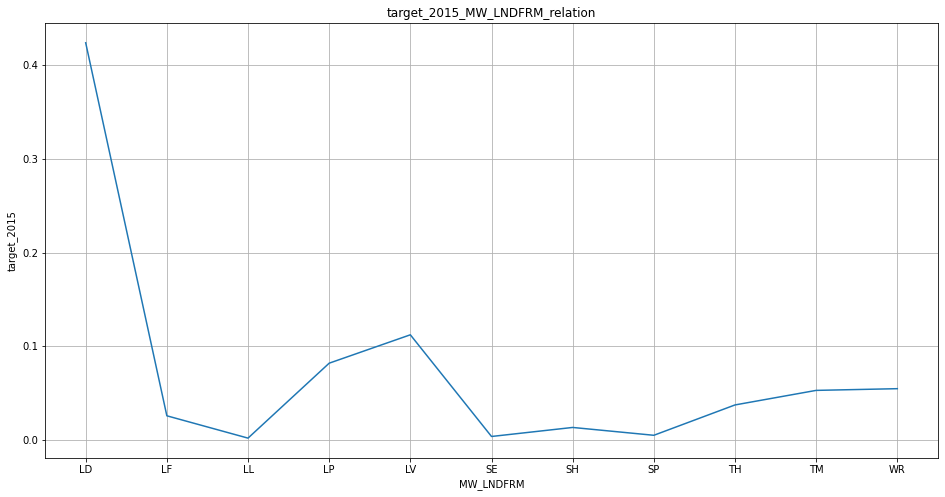

In [17]:
plot_var_target_corr(full_data, "MW_LNDFRM", "target_2015")

As we can see in the Plot Above, the Average Flood value is relatively high for the category "LD"

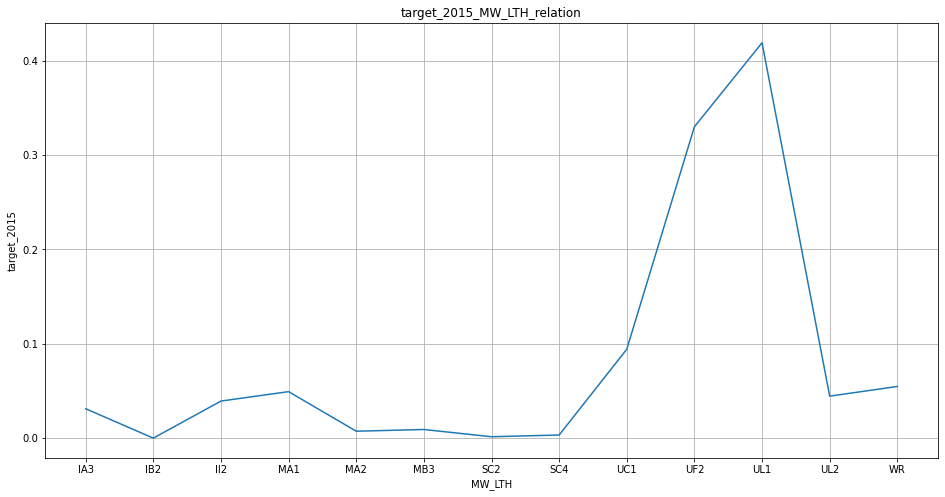

In [18]:
plot_var_target_corr(full_data, "MW_LTH", "target_2015")

Same here, for the "MW_LTH" feature, the pattern is clear : 
* we have higher risk of Flood when MW_LTH is either UF2 or UL1

In [19]:
from sklearn.preprocessing import LabelEncoder
def le_enc(df, feat) :
    le = LabelEncoder()
    for i in feat :
        df[str(i)+'_le'] = le.fit_transform(df[i].astype(str))
    return df

In [20]:
full_data = le_enc(full_data, ['MW_LNDFRM'])
full_data = le_enc(full_data, ['MW_LTH'])

In [21]:
full_data.head()

,X,Y,target_2015,elevation,precip-17,precip-16,precip-15,precip-14,precip-13,precip-12,...,K,SREACT1,SDESC1_SDE,ALT2,COLOR,SOIL_GROUP,MW_LNDFRM,MW_LTH,MW_LNDFRM_le,MW_LTH_le
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,4,56,150.0,5,8,TH,II2,8,2
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,4,56,150.0,5,8,TH,II2,8,2
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,4,56,150.0,5,8,TH,II2,8,2
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,4,21,150.0,5,8,TH,II2,8,2
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0,4,21,150.0,5,8,SP,SC4,7,7


* The most Floos=ding Factors (Next to Precipitations) is obviously the Distance to Large Rivers and Water Areas (Especially Flooding Rivers).
* So we tried to extract, from Malawi Map in Masdap website, the the points relative to these variables.

In [22]:
water1 = (35.72417, -15.34428)
water2 = (34.80832, -16.07994)
water3 = (35.11360, -16.47703)

water4 = (34.89457, -16.11494)
water5 = (34.81079, -16.15970)
water6 = (34.93818, -16.26414)
water7 = (35.73581, -15.50438)
water8 = (35.14247, -16.46957)
water9 = (35.07820, -16.51089)
water10 = (35.10115, -16.49826)
water11 = (35.11492, -16.47760)

In [23]:
# The idea is to Calculate the Distance from these points to 
# all the Points in the Train and then Take the Min Distance.
# To accomplish that we will use Vincenty Library : 

In [24]:
!pip install vincenty

  Created wheel for vincenty: filename=vincenty-0.1.4-py3-none-any.whl size=3079 sha256=031ac0009394837989a74f6ce2f2d6ad0e05d163210dcfd986ffab2aad458e2f
  Stored in directory: /root/.cache/pip/wheels/2f/4d/df/6e2ce31c63c93508b38ed9098c1483e7616b55a6ddabcd2f5b
Successfully built vincenty
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [25]:
from vincenty import vincenty

In [26]:
start = time.time()
full_data["distance_to_water1"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water1),axis=1)
full_data["distance_to_water2"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water2),axis=1)
full_data["distance_to_water3"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water3),axis=1)

full_data["distance_to_water4"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water4),axis=1)
full_data["distance_to_water5"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water5),axis=1)
full_data["distance_to_water6"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water6),axis=1)
full_data["distance_to_water7"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water7),axis=1)
full_data["distance_to_water8"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water8),axis=1)
full_data["distance_to_water9"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water9),axis=1)
full_data["distance_to_water10"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water10),axis=1)
full_data["distance_to_water11"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),water11),axis=1)
print("Processing time : {}".format(time.time() - start))

Processing time : 25.79565954208374


In [27]:
water_dist_feats = ['distance_to_water1',
       'distance_to_water2', 'distance_to_water3', 'distance_to_water4',
       'distance_to_water5', 'distance_to_water6', 'distance_to_water7',
       'distance_to_water8', 'distance_to_water9', 'distance_to_water10',
       'distance_to_water11']

# Here, we will take the minimum accross the X axis : 
full_data["shortest_distance_to_water_area"] = full_data[water_dist_feats].min(axis=1)
full_data = full_data.drop(water_dist_feats, 1)
full_data.head()

,X,Y,target_2015,elevation,precip-17,precip-16,precip-15,precip-14,precip-13,precip-12,...,SREACT1,SDESC1_SDE,ALT2,COLOR,SOIL_GROUP,MW_LNDFRM,MW_LTH,MW_LNDFRM_le,MW_LTH_le,shortest_distance_to_water_area
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,4,56,150.0,5,8,TH,II2,8,2,62.795062
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,4,56,150.0,5,8,TH,II2,8,2,63.029406
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,4,56,150.0,5,8,TH,II2,8,2,63.276203
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,4,21,150.0,5,8,TH,II2,8,2,63.535306
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,4,21,150.0,5,8,SP,SC4,7,7,63.806566


In [28]:
full_data.shortest_distance_to_water_area.describe()

count    32932.000000
mean        35.018534
std         19.549335
min          0.091838
25%         18.316135
50%         34.478023
75%         50.085552
max         83.636713
Name: shortest_distance_to_water_area, dtype: float64

* We will do the same for Rivers.
* we will input Manually some Relevant Points on the Map that describes Large Rivers.

In [29]:
river1 = (34.64799, -15.30411)
river2 = (34.93720, -15.24443)
river3 = (34.98770, -15.28116)
river4 = (34.97622, -15.34772)
river5 = (35.06115, -15.30870)

river6 = (35.12771, -15.25361)
river7 = (35.31593, -15.21918)
river8 = (35.27921, -15.31329)
river9 = (34.49190, -15.63923)
river10 = (34.85227, -15.48085)

river11 = (35.24018, -15.69661)
river12 = (35.41693, -15.59103)
river13 = (35.39168, -15.83892)
river14 = (35.48579, -15.81368)
river15 = (35.58449, -15.88254)

river16 = (35.47890, -15.97894)
river17 = (35.66253, -15.99042)
river18 = (35.46972, -16.10748)
river19 = (35.28609, -16.17864)
river20 = (35.31593, -16.05010)

river21 = (35.28150, -16.30258)
river22 = (35.26084, -16.40358)
river23 = (34.81325, -16.03403)
river24 = (34.87752, -16.08682)
river25 = (34.91425, -16.16027)

river26 = (34.76275, -16.15798)
river27 = (34.62733, -16.10289)
river28 = (34.88670, -16.29111)
river29 = (34.93490, -16.36456)
river30 = (35.06115, -16.47933)

river31 = (35.03819, -16.35308)
river32 = (34.91654, -16.47703)
river33 = (35.11394, -16.52982)
river34 = (35.16673, -16.61934)
river35 = (35.07492, -16.61246)

In [30]:
start = time.time()

full_data["distance_to_river1"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river1),axis=1)
full_data["distance_to_river2"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river2),axis=1)
full_data["distance_to_river3"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river3),axis=1)
full_data["distance_to_river4"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river4),axis=1)
full_data["distance_to_river5"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river5),axis=1)

full_data["distance_to_river6"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river6),axis=1)
full_data["distance_to_river7"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river7),axis=1)
full_data["distance_to_river8"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river8),axis=1)
full_data["distance_to_river9"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river9),axis=1)
full_data["distance_to_river10"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river10),axis=1)

full_data["distance_to_river11"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river11),axis=1)
full_data["distance_to_river12"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river12),axis=1)
full_data["distance_to_river13"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river13),axis=1)
full_data["distance_to_river14"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river14),axis=1)
full_data["distance_to_river15"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river15),axis=1)

full_data["distance_to_river16"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river16),axis=1)
full_data["distance_to_river17"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river17),axis=1)
full_data["distance_to_river18"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river18),axis=1)
full_data["distance_to_river19"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river19),axis=1)
full_data["distance_to_river20"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river20),axis=1)

full_data["distance_to_river21"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river21),axis=1)
full_data["distance_to_river22"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river22),axis=1)
full_data["distance_to_river23"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river23),axis=1)
full_data["distance_to_river24"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river24),axis=1)
full_data["distance_to_river25"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river25),axis=1)

full_data["distance_to_river26"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river26),axis=1)
full_data["distance_to_river27"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river27),axis=1)
full_data["distance_to_river28"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river28),axis=1)
full_data["distance_to_river29"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river29),axis=1)
full_data["distance_to_river30"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river30),axis=1)

full_data["distance_to_river31"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river31),axis=1)
full_data["distance_to_river32"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river32),axis=1)
full_data["distance_to_river33"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river33),axis=1)
full_data["distance_to_river34"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river34),axis=1)
full_data["distance_to_river35"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),river35),axis=1)

print("Processing time : {}".format(time.time() - start))

Processing time : 83.34101128578186


In [31]:
dist_river_list = [
 'distance_to_river1',
 'distance_to_river2',
 'distance_to_river3',
 'distance_to_river4',
 'distance_to_river5',
 'distance_to_river6',
 'distance_to_river7',
 'distance_to_river8',
 'distance_to_river9',
 'distance_to_river10',
 'distance_to_river11',
 'distance_to_river12',
 'distance_to_river13',
 'distance_to_river14',
 'distance_to_river15',
 'distance_to_river16',
 'distance_to_river17',
 'distance_to_river18',
 'distance_to_river19',
 'distance_to_river20',
 'distance_to_river21',
 'distance_to_river22',
 'distance_to_river23',
 'distance_to_river24',
 'distance_to_river25',
 'distance_to_river26',
 'distance_to_river27',
 'distance_to_river28',
 'distance_to_river29',
 'distance_to_river30',
 'distance_to_river31',
 'distance_to_river32',
 'distance_to_river33',
 'distance_to_river34',
 'distance_to_river35']

full_data["shortest_distance_to_river"] = full_data[dist_river_list].min(axis=1)
full_data = full_data.drop(dist_river_list, 1)
print(full_data.shape)
full_data.head()

(32932, 43)


,X,Y,target_2015,elevation,precip-17,precip-16,precip-15,precip-14,precip-13,precip-12,...,SDESC1_SDE,ALT2,COLOR,SOIL_GROUP,MW_LNDFRM,MW_LTH,MW_LNDFRM_le,MW_LTH_le,shortest_distance_to_water_area,shortest_distance_to_river
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,56,150.0,5,8,TH,II2,8,2,62.795062,35.804609
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,56,150.0,5,8,TH,II2,8,2,63.029406,35.171073
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,56,150.0,5,8,TH,II2,8,2,63.276203,34.550406
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,21,150.0,5,8,TH,II2,8,2,63.535306,33.943316
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,21,150.0,5,8,SP,SC4,7,7,63.806566,33.350543


In [32]:
to_use_features = ['Square_ID','target_2015'] + ['LC_Type1_mode', 'X', 'Y',
        'elevation', 'precip-1', 'precip-10',
        'shortest_distance_to_river', 'precip-11', 'precip-12',
        'precip-13', 'precip-14', 'precip-15','shortest_distance_to_water_area', 
        'precip-16', 'precip-17', 'precip-2', 'precip-3', 'precip-4','SOIL_TYPE',
        'PRIMARY', 'SECONDARY','slope', 'precip-5', 'precip-6', 'precip-7', 'precip-8', 
        'precip-9','DRAINAGE', 'FLOODING', 'PONDING','EROSION','K', 'SREACT1',
        'SDESC1_SDE', 'ALT2', 'COLOR','MW_LNDFRM_le','MW_LTH_le', 'SOIL_GROUP']

Now let's Scale our data before fitting the estimators : 

In [45]:
from sklearn import preprocessing
new_full_data = full_data[to_use_features].copy()
for i in to_use_features :
    if i not in ["Square_ID","target_2015"]:
        new_full_data[i] = preprocessing.scale(new_full_data[i])

We almost tested all the SKlearn estimators on this set of features and the Top two Performing ones were : 
* RandomForest Regressor
* Gradient Boosting Trees Regressor

In [46]:
def plot_rf_feat_importances(rf_model, data, drop) :
    data = data.drop(drop, 1)
    feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = data.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    return feature_importances

In [47]:
def Random_Forest_Submit(df, TARGET) :
    to_remove = ["Square_ID"]
    train_df = df[df[TARGET].notnull()]
    train_df = train_df.drop(to_remove, 1)
    test_df = df[df[TARGET].isnull()]
    
    print("Starting RandomForest. Train shape: {}".format(train_df.shape))
    print("Feature used are : ")
    print(list(train_df.columns))
    X_train, y_train = train_df.drop(TARGET,1), train_df[TARGET]
    rf = RandomForestRegressor(n_jobs=4, random_state=1995, max_depth=9, criterion="mae",
                               max_features=.8, max_samples=.9, n_estimators=50, verbose=2)
    rf.fit(X_train, y_train)
    x_test = test_df.drop(to_remove, 1)
    x_test = x_test.drop(TARGET, 1)
    y_pred = rf.predict(x_test)
    test_df[TARGET] = y_pred

    return test_df[["Square_ID",TARGET]], rf

In [50]:
submission, rf_model = Random_Forest_Submit(new_full_data, "target_2015")

Starting RandomForest. Train shape: (16466, 40)
Feature used are : 
['target_2015', 'LC_Type1_mode', 'X', 'Y', 'elevation', 'precip-1', 'precip-10', 'shortest_distance_to_river', 'precip-11', 'precip-12', 'precip-13', 'precip-14', 'precip-15', 'shortest_distance_to_water_area', 'precip-16', 'precip-17', 'precip-2', 'precip-3', 'precip-4', 'SOIL_TYPE', 'PRIMARY', 'SECONDARY', 'slope', 'precip-5', 'precip-6', 'precip-7', 'precip-8', 'precip-9', 'DRAINAGE', 'FLOODING', 'PONDING', 'EROSION', 'K', 'SREACT1', 'SDESC1_SDE', 'ALT2', 'COLOR', 'MW_LNDFRM_le', 'MW_LTH_le', 'SOIL_GROUP']
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.3min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  6.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
# Now let's plot features Importances according to RF Estimator : 

In [52]:
plot_rf_feat_importances(rf_model, new_full_data[new_full_data.target_2015.notnull()][to_use_features], ["Square_ID"]+["target_2015"])

,importance
elevation,0.612990
slope,0.077714
X,0.067195
Y,0.051954
shortest_distance_to_river,0.026634
MW_LNDFRM_le,0.026339
shortest_distance_to_water_area,0.023324
SECONDARY,0.014463
precip-14,0.011844
LC_Type1_mode,0.008487


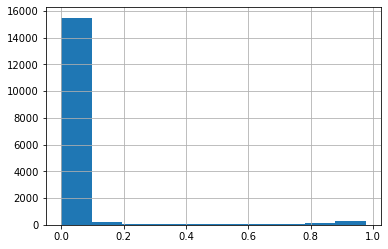

In [53]:
# Let's check the Output Histogram : 
submission.target_2015.hist()

In [55]:
submission.columns = ['Square_ID','target_2019']

In [56]:
submission.to_csv('RF_first_prediction.csv', index=False)

So far, this is the first prediction using RF Model.
As we will see later, we will use a different Set of features with RF and then apply an Ensembling.

Now let's Predict the Output using GBT : 

In [57]:
def GBT_Submit(df, TARGET) :
    to_remove = ["Square_ID"]
    train_df = df[df[TARGET].notnull()]
    train_df = train_df.drop(to_remove, 1)
    test_df = df[df[TARGET].isnull()]
    
    print("Starting GBT. Train shape: {}".format(train_df.shape))
    print("Feature used are : ")
    print(list(train_df.columns))
    X_train, y_train = train_df.drop(TARGET,1), train_df[TARGET]
    gbt = GradientBoostingRegressor(n_estimators=15, random_state=1995, max_depth=7,
                                   criterion="mae", verbose=2)
    gbt.fit(X_train, y_train)
    x_test = test_df.drop(to_remove, 1)
    x_test = x_test.drop(TARGET, 1)
    y_pred = gbt.predict(x_test)
    test_df[TARGET] = y_pred

    return test_df[["Square_ID",TARGET]], gbt

In [58]:
submission_gbt, gbt_model = GBT_Submit(new_full_data, "target_2015")

Starting GBT. Train shape: (16466, 40)
Feature used are : 
['target_2015', 'LC_Type1_mode', 'X', 'Y', 'elevation', 'precip-1', 'precip-10', 'shortest_distance_to_river', 'precip-11', 'precip-12', 'precip-13', 'precip-14', 'precip-15', 'shortest_distance_to_water_area', 'precip-16', 'precip-17', 'precip-2', 'precip-3', 'precip-4', 'SOIL_TYPE', 'PRIMARY', 'SECONDARY', 'slope', 'precip-5', 'precip-6', 'precip-7', 'precip-8', 'precip-9', 'DRAINAGE', 'FLOODING', 'PONDING', 'EROSION', 'K', 'SREACT1', 'SDESC1_SDE', 'ALT2', 'COLOR', 'MW_LNDFRM_le', 'MW_LTH_le', 'SOIL_GROUP']
      Iter       Train Loss   Remaining Time 
         1           0.0474           12.12m
         2           0.0435           11.28m
         3           0.0403           10.38m
         4           0.0379            9.50m
         5           0.0359            8.65m
         6           0.0343            7.79m
         7           0.0331            6.93m
         8           0.0321            6.07m
         9          

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
plot_rf_feat_importances(gbt_model, new_full_data[new_full_data.target_2015.notnull()], ["Square_ID"]+["target_2015"])

,importance
elevation,6.930829e-01
slope,9.499354e-02
Y,8.315189e-02
X,3.370550e-02
SECONDARY,2.274781e-02
shortest_distance_to_river,2.059657e-02
shortest_distance_to_water_area,1.491742e-02
LC_Type1_mode,8.891660e-03
PONDING,5.904285e-03
SOIL_TYPE,3.608269e-03


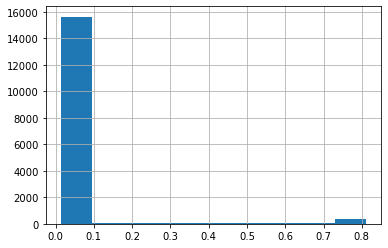

In [61]:
submission_gbt.target_2015.hist()

In [62]:
submission_gbt.columns = ['Square_ID','target_2019']
submission_gbt.to_csv('GBT_first_prediction.csv', index=False)

Now with the Ensembling of the two Predictions : 

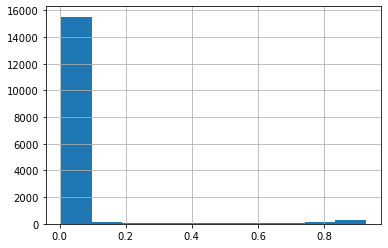

In [64]:
first_ensemble = submission.copy()
first_ensemble['target_2019'] = (submission.target_2019.values)*0.7 + (submission_gbt.target_2019.values)*0.3
first_ensemble.target_2019.hist()

In [65]:
first_ensemble.to_csv("./ensemble_GBT_RF_First.csv", index=False)

In the Next of Notebook, we will use the Same models and then Ensembling but this time we will use a different Set of features.

Now, we will extract coordinates of the Shire River and Mwanza River : the Two most Flooding Rivers in Malawi.
* I will use "Waterways" in Shapefile format extracted from "masdap" website.
* for the processing of the Shapefile : I'll use GeoPandas

**NB** : I didn't used DivaGis for this task because DivaGis can only do Aggregations when we Have Polygon like Shapes --> this file is not ! 

You can find this data on the following link : 
* http://www.masdap.mw/layers/geonode:waterways

In [66]:
import geopandas as gpd

In [67]:
waterways = gpd.read_file("../input/water-ways/waterways.shp")

In [68]:
shire_list = []
for index, row in waterways.iterrows():
    if (row["name"] == "Shire" and row["type"] == "river"):
        for i in list(row["geometry"].coords):
            shire_list.append(i)
            

mwanza_list = []
for index, row in waterways.iterrows():
    if (row["name"] == "Mwanza" and row["type"] == "river"):
        for i in list(row["geometry"].coords):
            mwanza_list.append(i)

In [69]:
shire_X = []
shire_Y = []
for i in shire_list:
    shire_X.append(i[0])
    shire_Y.append(i[1])
print(len(shire_X))
print(len(shire_Y))

2063
2063


In [70]:
mwanza_X = []
mwanza_Y = []
for i in mwanza_list:
    mwanza_X.append(i[0])
    mwanza_Y.append(i[1])
print(len(mwanza_X))
print(len(mwanza_Y))

652
652


In [71]:
# Let's convert those to Pandas Dataframes : 

shire_df = pd.DataFrame()
shire_df["shire_X"] = shire_X
shire_df["shire_Y"] = shire_Y

mwanza_df = pd.DataFrame()
mwanza_df["mwanza_X"] = mwanza_X
mwanza_df["mwanza_Y"] = mwanza_Y

**After extracting Rivers Coordinates, Following is the Visualization of 2015 Floods and the Shire Mwanza Rivers :**
1. In Red : 2015 Flooded Areas
2. Black thin Lines : Shire & Mwanza Rivers
3. In Blue : Our Prediction for 2019

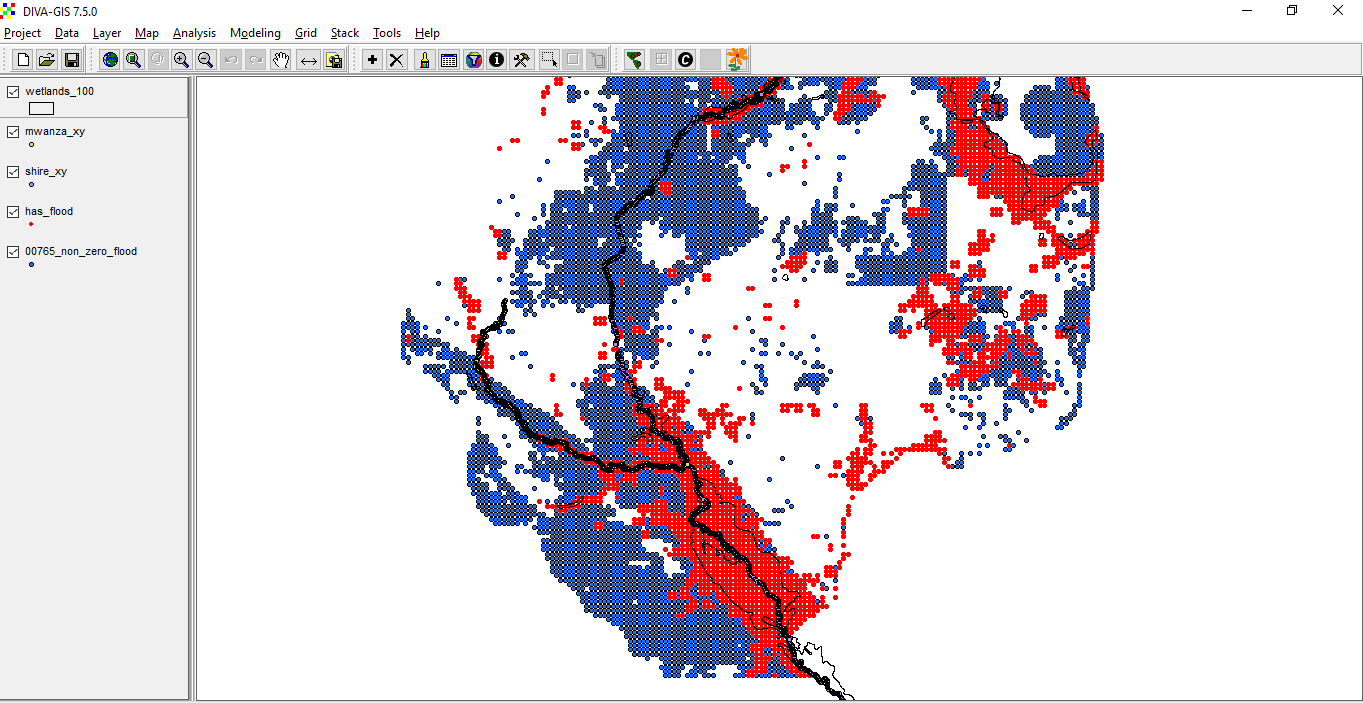

**Obviously, most of the Flooding Areas in 2015 (in Red) are around Shire and Mwanza Rivers --> Our assumption is right !**

Again, we will Calculate the Shortest Distance from each Point in our Train_Test file to the Rivers

In [72]:
# Here, We're taking the X,Y coordinates for the Train
x_y = full_data[full_data.target_2015.notnull()].reset_index(drop=True)[["X","Y"]]
print(x_y.shape)

(16466, 2)


In [73]:
# This will take Some Time to finish, Grab a Coffee :) 

start = time.time()

for i in range(len(mwanza_df)) :
    temp_cpl = (float(mwanza_df.loc[i, "mwanza_X"]), float(mwanza_df.loc[i, "mwanza_Y"]))
    x_y["mwanza"+str(i)] = x_y.apply(lambda row : vincenty((row["X"],row["Y"]),temp_cpl),axis=1)
    
print("Processing time : {}".format(time.time() - start))

Processing time : 769.8424379825592


In [74]:
new_x_y = full_data[full_data.target_2015.notnull()].reset_index(drop=True)[["X","Y"]]
new_x_y["shortest_mwanza_dist"] = x_y[[i for i in list(x_y.columns) if i not in ["X","Y"]]].min(axis=1)
new_x_y = pd.concat([new_x_y, new_x_y], 0).reset_index(drop=True)

shortest_dist_to_mwanza = new_x_y.copy()
del new_x_y

In [75]:
full_data["shortest_distance_to_mwanza"] = shortest_dist_to_mwanza["shortest_mwanza_dist"]

The same Here will be done on Shire 

In [76]:
# Here, We're taking the X,Y coordinates for the Train
x_y = full_data[full_data.target_2015.notnull()].reset_index(drop=True)[["X","Y"]]
print(x_y.shape)

(16466, 2)


In [77]:
# This will take Some Time to finish, Grab a Coffee :) 

start = time.time()

for i in range(len(shire_df)) :
    temp_cpl = (float(shire_df.loc[i, "shire_X"]), float(shire_df.loc[i, "shire_Y"]))
    x_y["shire"+str(i)] = x_y.apply(lambda row : vincenty((row["X"],row["Y"]),temp_cpl),axis=1)
    
print("Processing time : {}".format(time.time() - start))

Processing time : 2683.259916305542


In [78]:
new_x_y = full_data[full_data.target_2015.notnull()].reset_index(drop=True)[["X","Y"]]
new_x_y["shortest_shire_dist"] = x_y[[i for i in list(x_y.columns) if i not in ["X","Y"]]].min(axis=1)
new_x_y = pd.concat([new_x_y, new_x_y], 0).reset_index(drop=True)

shortest_dist_to_shire = new_x_y.copy()
del new_x_y

In [79]:
full_data["shortest_distance_to_shire"] = shortest_dist_to_shire["shortest_shire_dist"]

Now with Distances to Lakes.
* The most important Lake in Southern Malawi is the Chilwa Lake.
* We found Also other small Lakes that we took into consideration.

In [80]:
# small _lakes :
lake1 = (34.81825, -16.08453)
lake2 = (34.79530, -16.08682)
lake3 = (34.89629, -16.11666)
lake4 = (34.80907, -16.15798)
lake5 = (34.93761, -16.26586)

In [81]:
# feature distance to small lakes
start = time.time()
full_data["distance_to_small1"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),lake1),axis=1)
full_data["distance_to_small2"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),lake2),axis=1)
full_data["distance_to_small3"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),lake3),axis=1)
full_data["distance_to_small4"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),lake4),axis=1)
full_data["distance_to_small5"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),lake5),axis=1)

In [82]:
# wa : water area
dist_wa = ['distance_to_small1',
       'distance_to_small2', 'distance_to_small3', 'distance_to_small4',
       'distance_to_small5']

full_data["shortest_distance_to_small_wa"] = full_data[dist_wa].min(axis=1)
full_data = full_data.drop(dist_wa, 1)
full_data.head(2)

,X,Y,target_2015,elevation,precip-17,precip-16,precip-15,precip-14,precip-13,precip-12,...,SOIL_GROUP,MW_LNDFRM,MW_LTH,MW_LNDFRM_le,MW_LTH_le,shortest_distance_to_water_area,shortest_distance_to_river,shortest_distance_to_mwanza,shortest_distance_to_shire,shortest_distance_to_small_wa
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,8,TH,II2,8,2,62.795062,35.804609,18.281997,53.385065,61.560849
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,8,TH,II2,8,2,63.029406,35.171073,18.375719,53.242752,61.809294


In [83]:
# Chilwa Lake :
# These are the Border Points to Chilwa Lake : 
chilwa1 = (35.59178, -15.21459)
chilwa2 = (35.59408, -15.25361)
chilwa3 = (35.58260, -15.26968)
chilwa4 = (35.5688, -1529034)
chilwa5 = (35.61244, -15.31329)

chilwa6 = (35.62851, -15.34772)
chilwa7 = (35.59178, -15.34083)
chilwa8 = (35.57112, -15.34313)
chilwa9 = (35.58949, -15.36379)
chilwa10 = (35.61014, -15.38674)

chilwa11 = (35.63080, -15.40510)
chilwa12 = (35.65605, -15.43724)
chilwa13 = (35.69278, -15.46708)
chilwa14 = (35.72950, -15.48544)
chilwa15 = (35.80066, -15.48085)

chilwa16 = (35.83738, -15.45560)
chilwa17 = (35.82820, -15.39592)
chilwa18 = (35.84197, -15.37297)
chilwa19 = (35.81902, -15.30870)
chilwa20 = (35.79377, -15.28345)

chilwa21 = (35.77541, -15.25820)
chilwa22 = (35.78000, -15.21000)

In [84]:
# feature dist to chilwa lake
full_data["distance_to_chilwa1"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa1),axis=1)
full_data["distance_to_chilwa2"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa2),axis=1)
full_data["distance_to_chilwa3"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa3),axis=1)
full_data["distance_to_chilwa4"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa4),axis=1)
full_data["distance_to_chilwa5"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa5),axis=1)

full_data["distance_to_chilwa6"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa6),axis=1)
full_data["distance_to_chilwa7"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa7),axis=1)
full_data["distance_to_chilwa8"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa8),axis=1)
full_data["distance_to_chilwa9"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa9),axis=1)
full_data["distance_to_chilwa10"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa10),axis=1)

full_data["distance_to_chilwa11"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa11),axis=1)
full_data["distance_to_chilwa12"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa12),axis=1)
full_data["distance_to_chilwa13"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa13),axis=1)
full_data["distance_to_chilwa14"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa14),axis=1)
full_data["distance_to_chilwa15"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa15),axis=1)

full_data["distance_to_chilwa16"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa16),axis=1)
full_data["distance_to_chilwa17"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa17),axis=1)
full_data["distance_to_chilwa18"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa18),axis=1)
full_data["distance_to_chilwa19"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa19),axis=1)
full_data["distance_to_chilwa20"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa20),axis=1)

full_data["distance_to_chilwa21"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa21),axis=1)
full_data["distance_to_chilwa22"] = full_data.apply(lambda row : vincenty((row["X"],row["Y"]),chilwa22),axis=1)

In [85]:
dist_chilwa =  ['distance_to_chilwa1',
 'distance_to_chilwa2',
 'distance_to_chilwa3',
 'distance_to_chilwa4',
 'distance_to_chilwa5',
 'distance_to_chilwa6',
 'distance_to_chilwa7',
 'distance_to_chilwa8',
 'distance_to_chilwa9',
 'distance_to_chilwa10',
 'distance_to_chilwa11',
 'distance_to_chilwa12',
 'distance_to_chilwa13',
 'distance_to_chilwa14',
 'distance_to_chilwa15',
 'distance_to_chilwa16',
 'distance_to_chilwa17',
 'distance_to_chilwa18',
 'distance_to_chilwa19',
 'distance_to_chilwa20',
 'distance_to_chilwa21',
 'distance_to_chilwa22']

print(full_data.shape)
full_data["shortest_distance_to_chilwa"] = full_data[dist_chilwa].min(axis=1)
full_data = full_data.drop(dist_chilwa, 1)
print(full_data.shape)
full_data.head()

(32932, 68)
(32932, 47)


,X,Y,target_2015,elevation,precip-17,precip-16,precip-15,precip-14,precip-13,precip-12,...,MW_LNDFRM,MW_LTH,MW_LNDFRM_le,MW_LTH_le,shortest_distance_to_water_area,shortest_distance_to_river,shortest_distance_to_mwanza,shortest_distance_to_shire,shortest_distance_to_small_wa,shortest_distance_to_chilwa
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,TH,II2,8,2,62.795062,35.804609,18.281997,53.385065,61.560849,154.402384
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,TH,II2,8,2,63.029406,35.171073,18.375719,53.242752,61.809294,154.098239
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,TH,II2,8,2,63.276203,34.550406,18.510910,53.115940,62.070325,153.798922
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,TH,II2,8,2,63.535306,33.943316,18.682315,53.004741,62.343785,153.504460
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,SP,SC4,7,7,63.806566,33.350543,18.897018,52.909252,62.629510,153.214882


Let's Calculate the Shortest Distance To Lakes and Rivers : 

In [86]:
full_data["new_short_wa"] = full_data[["shortest_distance_to_chilwa","shortest_distance_to_small_wa"]].min(axis=1)
full_data["new_short_river"] = full_data[["shortest_distance_to_mwanza","shortest_distance_to_shire"]].min(axis=1)

Some Additional GeoSpatial Features using Pygeohash : 

In [87]:
!pip -q install pygeohash
import pygeohash as pgh
from sklearn.preprocessing import LabelEncoder
def le_enc(df, feat) :
    le = LabelEncoder()
    for i in feat :
        df[str(i)+'_le'] = le.fit_transform(df[i].astype(str))
    return df

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [88]:
for j in range(4,6):
    full_data['hash'+str(j)] = full_data.apply(lambda cord: pgh.encode(cord.X,cord.Y, j), axis=1)
full_data = le_enc(full_data, ['hash4'])
full_data = le_enc(full_data, ['hash5'])

In [89]:
features_to_use = ['Square_ID','target_2015']+['X', 'Y','slope','elevation','LC_Type1_mode',
        'precip-1', 'precip-10','precip-9',
        'precip-11', 'precip-12',
        'precip-13', 'precip-14', 'precip-15',
        'precip-16', 'precip-17', 'precip-2', 'precip-3', 'precip-4'
        , 'precip-5', 'precip-6', 'precip-7', 'precip-8']+['new_short_wa','new_short_river']+['shortest_distance_to_small_wa',
 'shortest_distance_to_chilwa',
 'shortest_distance_to_mwanza',
 'shortest_distance_to_shire']+['shortest_distance_to_water_area',
                                'shortest_distance_to_river']+['hash4_le','hash5_le']

Scale the Data : 

In [90]:
from sklearn import preprocessing
new_full_data = full_data[features_to_use].copy()
for i in features_to_use :
    if i not in ["Square_ID","target_2015"]:
        new_full_data[i] = preprocessing.scale(new_full_data[i])

In [91]:
def Random_Forest_Submit(df, TARGET) :
    to_remove = ["Square_ID"]
    train_df = df[df[TARGET].notnull()]
    train_df = train_df.drop(to_remove, 1)
    test_df = df[df[TARGET].isnull()]
    
    print("Starting RandomForest. Train shape: {}".format(train_df.shape))
    print("Feature used are : ")
    print(list(train_df.columns))
    X_train, y_train = train_df.drop(TARGET,1), train_df[TARGET]
    rf = RandomForestRegressor(n_jobs=4, random_state=1995, max_depth=9, criterion="mae",
                               max_features=.8, max_samples=.9, n_estimators=50, verbose=2)
    rf.fit(X_train, y_train)
    x_test = test_df.drop(to_remove, 1)
    x_test = x_test.drop(TARGET, 1)
    y_pred = rf.predict(x_test)
    test_df[TARGET] = y_pred

    return test_df[["Square_ID",TARGET]], rf

In [92]:
submission, rf_model = Random_Forest_Submit(new_full_data, "target_2015")

Starting RandomForest. Train shape: (16466, 33)
Feature used are : 
['target_2015', 'X', 'Y', 'slope', 'elevation', 'LC_Type1_mode', 'precip-1', 'precip-10', 'precip-9', 'precip-11', 'precip-12', 'precip-13', 'precip-14', 'precip-15', 'precip-16', 'precip-17', 'precip-2', 'precip-3', 'precip-4', 'precip-5', 'precip-6', 'precip-7', 'precip-8', 'new_short_wa', 'new_short_river', 'shortest_distance_to_small_wa', 'shortest_distance_to_chilwa', 'shortest_distance_to_mwanza', 'shortest_distance_to_shire', 'shortest_distance_to_water_area', 'shortest_distance_to_river', 'hash4_le', 'hash5_le']
building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.0min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  7.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
plot_rf_feat_importances(rf_model, new_full_data[new_full_data.target_2015.notnull()][features_to_use], ["Square_ID"]+["target_2015"])

,importance
elevation,0.630143
shortest_distance_to_chilwa,0.057791
slope,0.056803
shortest_distance_to_shire,0.035125
X,0.028010
shortest_distance_to_river,0.021803
shortest_distance_to_mwanza,0.020751
new_short_river,0.020399
Y,0.019670
shortest_distance_to_water_area,0.017195


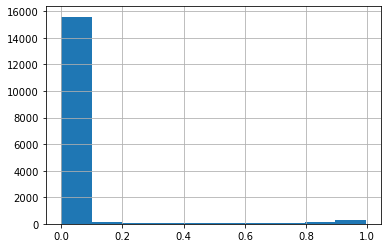

In [94]:
# Let's check the Output Histogram : 
submission.target_2015.hist()

In [96]:
submission.columns = ['Square_ID','target_2019']
submission.to_csv('RF_second_prediction.csv', index=False)

In [97]:
def GBT_Submit(df, TARGET) :
    to_remove = ["Square_ID"]
    train_df = df[df[TARGET].notnull()]
    train_df = train_df.drop(to_remove, 1)
    test_df = df[df[TARGET].isnull()]
    
    print("Starting GBT. Train shape: {}".format(train_df.shape))
    print("Feature used are : ")
    print(list(train_df.columns))
    X_train, y_train = train_df.drop(TARGET,1), train_df[TARGET]
    gbt = GradientBoostingRegressor(n_estimators=15, random_state=1995, max_depth=7,
                                   criterion="mae", verbose=2)
    gbt.fit(X_train, y_train)
    x_test = test_df.drop(to_remove, 1)
    x_test = x_test.drop(TARGET, 1)
    y_pred = gbt.predict(x_test)
    test_df[TARGET] = y_pred

    return test_df[["Square_ID",TARGET]], gbt

In [98]:
submission_gbt, gbt_model = GBT_Submit(new_full_data, "target_2015")

Starting GBT. Train shape: (16466, 33)
Feature used are : 
['target_2015', 'X', 'Y', 'slope', 'elevation', 'LC_Type1_mode', 'precip-1', 'precip-10', 'precip-9', 'precip-11', 'precip-12', 'precip-13', 'precip-14', 'precip-15', 'precip-16', 'precip-17', 'precip-2', 'precip-3', 'precip-4', 'precip-5', 'precip-6', 'precip-7', 'precip-8', 'new_short_wa', 'new_short_river', 'shortest_distance_to_small_wa', 'shortest_distance_to_chilwa', 'shortest_distance_to_mwanza', 'shortest_distance_to_shire', 'shortest_distance_to_water_area', 'shortest_distance_to_river', 'hash4_le', 'hash5_le']
      Iter       Train Loss   Remaining Time 
         1           0.0472           13.85m
         2           0.0432           12.87m
         3           0.0399           11.87m
         4           0.0373           10.88m
         5           0.0353            9.89m
         6           0.0337            8.91m
         7           0.0324            7.92m
         8           0.0314            6.93m
         

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [99]:
plot_rf_feat_importances(gbt_model, new_full_data[new_full_data.target_2015.notnull()], ["Square_ID"]+["target_2015"])

,importance
elevation,0.688988
shortest_distance_to_chilwa,0.073192
slope,0.050407
Y,0.044479
X,0.023805
shortest_distance_to_small_wa,0.013980
shortest_distance_to_shire,0.013877
shortest_distance_to_mwanza,0.013728
shortest_distance_to_river,0.013242
new_short_river,0.012864


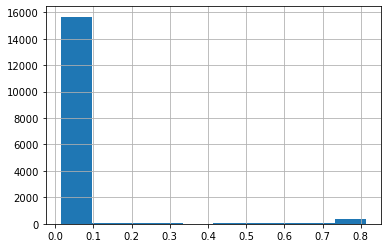

In [100]:
submission_gbt.target_2015.hist()

In [101]:
submission_gbt.columns = ['Square_ID','target_2019']
submission_gbt.to_csv('GBT_second_prediction.csv', index=False)

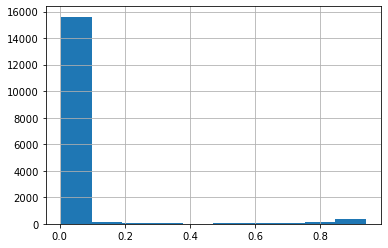

In [102]:
second_ensemble = submission.copy()
second_ensemble['target_2019'] = (submission.target_2019.values)*0.7 + (submission_gbt.target_2019.values)*0.3
second_ensemble.target_2019.hist()

Now we have Two Ensembles : 
* One using the First set Of features
* The second using another set of Features

We will do a meta Ensemble Now : 

In [103]:
meta_ensemble = pd.DataFrame()
meta_ensemble["Square_ID"] = submission_gbt.Square_ID
meta_ensemble["target_2019"] = first_ensemble.target_2019.values*0.2 + second_ensemble.target_2019.values*0.8
meta_ensemble.head()

,Square_ID,target_2019
16466,4e3c3896-14ce-11ea-bce5-f49634744a41,0.011275
16467,4e3c3897-14ce-11ea-bce5-f49634744a41,0.011275
16468,4e3c3898-14ce-11ea-bce5-f49634744a41,0.006387
16469,4e3c3899-14ce-11ea-bce5-f49634744a41,0.006387
16470,4e3c389a-14ce-11ea-bce5-f49634744a41,0.006387


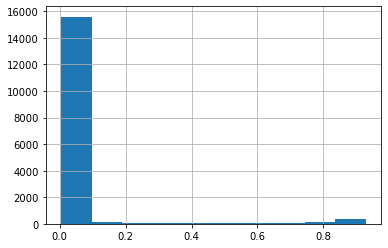

In [104]:
meta_ensemble.target_2019.hist()

In [105]:
meta_ensemble.to_csv("./00803.csv", index=False)

Now, With some Visualizations.
* We found that our model Outputs Floods in the Lake Chilwa which is incorrect, so we did set all these points to Zero before submitting : (NB : You can find the process how we got these points in the attachements : "Inside_Chilwa_Lake_Points" Folder)  

**This is the Inside Chilwa Lake Points (Green Points) : **

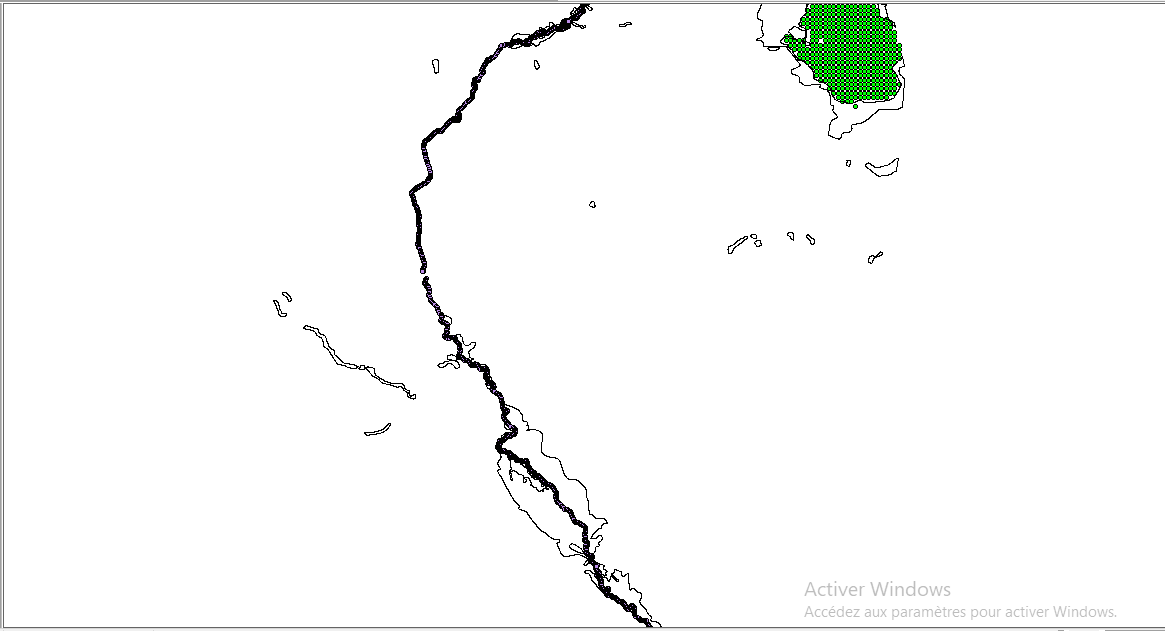

**This is 2015 Floods (In Red): **

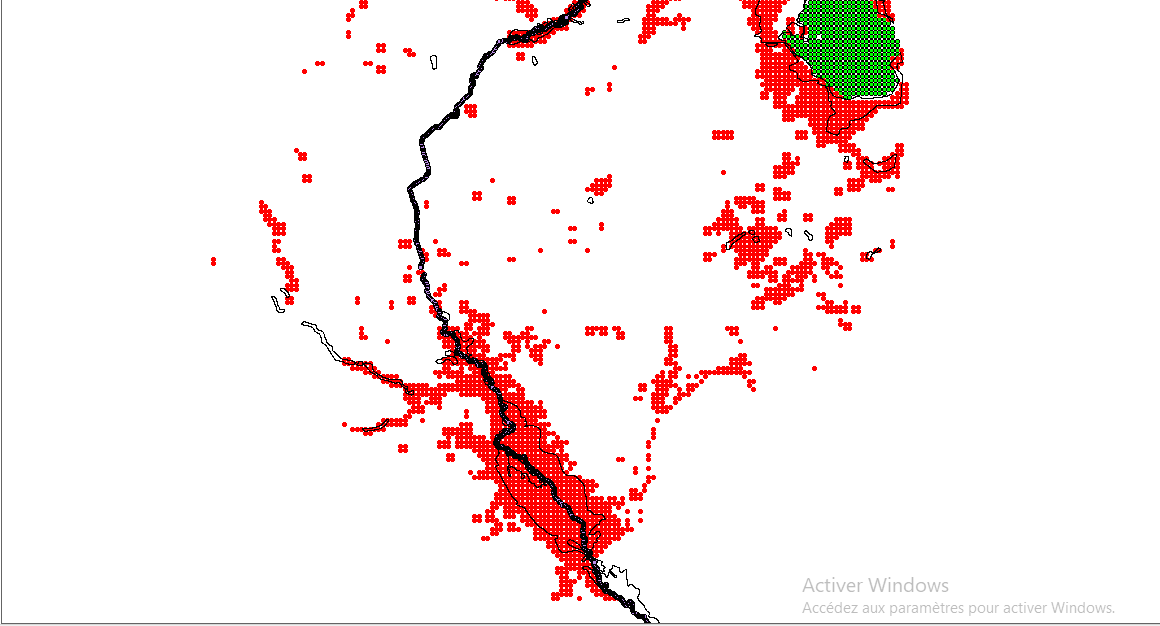

As We can See from the previous Visualizations :
* Chilwa Lake Inside Points Should not be considered as flooding in 2019 Predictons.

In [13]:
chilwa_inside_points = pd.read_csv("../input/chilwa-inside-points/chilwa_inside_points.csv")

In [15]:
chilwa_inside_points.head()

,X,COUNTRY,Y
0,35.58,Malawi,-15.35
1,35.58,Malawi,-15.34
2,35.59,Malawi,-15.36
3,35.59,Malawi,-15.35
4,35.59,Malawi,-15.34


In [111]:
meta_ensemble = pd.merge(left=meta_ensemble, right=test[["Square_ID","X","Y"]], on=["Square_ID"], how='left')

meta_ensemble = pd.merge(left=meta_ensemble, right=chilwa_inside_points, on=["X","Y"], how='left')
meta_ensemble["target_2019"][meta_ensemble.COUNTRY == "Malawi"] = 0.0

meta_ensemble = meta_ensemble[["Square_ID","target_2019"]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2023583c10>]],
      dtype=object)

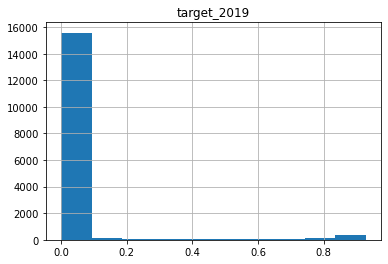

In [113]:
meta_ensemble.hist()

In [114]:
meta_ensemble.to_csv("./sub_rf_0.08039.csv", index=False)